In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
%cd /content/drive/MyDrive/mosaic/
root = "/content/drive/MyDrive/mosaic/"

/content/drive/MyDrive/mosaic


In [ ]:
#!unzip emnist-balanced-test.csv.zip
#!unzip emnist-balanced-train.csv.zip
#!unzip Emoji\ Dataset-20220328T053226Z-001.zip

In [ ]:
mp = dict()
for x in open("emnist-balanced-mapping.txt", 'r'):
  x = x.split(' ')
  mp[int(x[0])] = chr(int(x[-1][:-1]))

In [ ]:
mp.values()

dict_values(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'])

In [ ]:
train_df = pd.read_csv('emnist-balanced-train.csv')
test_df = pd.read_csv('emnist-balanced-test.csv')

In [ ]:
train_df = train_df[train_df['45'] > 9]
test_df = test_df[test_df['41'] > 9]
#train_df['45'] = train_df['45'].map(mp)
#test_df['41'] = test_df['41'].map(mp)
train_df.rename(columns={'45':'target'}, inplace=True)
test_df.rename(columns={'41':'target'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

M


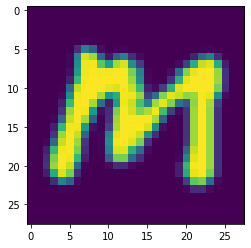

In [ ]:
i = 36
print(mp[train_df.loc[i,'target']])
plt.imshow(np.flip(np.rot90(train_df.loc[i,'0':].astype(int).values.reshape((28,28)), 3), 1))

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df.drop(columns='target').astype(float).values,train_df.target.values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df.drop(columns='target').astype(float).values,test_df.target.values))

In [ ]:
def transform(x,y):
  x = tf.image.flip_left_right(tf.image.rot90(tf.reshape(x,(28,28,1)), 3))
  x = tf.image.resize(x, [100,100])
  y = y - 10
  return x,y

def binarize(img, label, thresh=100):
  return tf.where(img > thresh, 255, 0), label

train_ds = train_ds.map(transform).map(binarize)
test_ds = test_ds.map(transform).map(binarize)

In [ ]:
train_ds = train_ds.batch(batch_size=32)
test_ds = test_ds.batch(batch_size=32)

In [ ]:
augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomRotation((-0.2,0.2), fill_mode='constant', fill_value=0),
     tf.keras.layers.RandomZoom(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3), fill_mode='constant', fill_value=0),
     tf.keras.layers.GaussianNoise(1)
    ]
)

In [ ]:
inp = tf.keras.layers.Input((100,100,1))
#aug = augmentation(inp)
norm = tf.keras.layers.Normalization()(inp)
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu')(norm)
mp1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1)
conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu')(mp1)
mp2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2)
conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=5, activation='relu')(mp2)
mp3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3)
dp = tf.keras.layers.Dropout(0.4)(mp3)
flat = tf.keras.layers.Flatten()(dp)
fc1 = tf.keras.layers.Dense(1024, activation='relu')(flat)
fc2 = tf.keras.layers.Dense(512, activation='relu')(fc1)
out = tf.keras.layers.Dense(len(mp)-10, activation='softmax')(fc2)

In [ ]:
model = tf.keras.Model(inputs=inp, outputs=out)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 normalization_1 (Normalizat  (None, 100, 100, 1)      3         
 ion)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      832       
                                                                 
 average_pooling2d_3 (Averag  (None, 50, 50, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        51264     
                                                                 
 average_pooling2d_4 (Averag  (None, 23, 23, 64)       0   

In [ ]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer='adam', loss=loss_fn)

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
2775/2775 [==============================] - 94s 34ms/step - loss: 0.6141 - val_loss: 0.3677
Epoch 2/5
2775/2775 [==============================] - 93s 34ms/step - loss: 0.3371 - val_loss: 0.3426
Epoch 3/5
2775/2775 [==============================] - 94s 34ms/step - loss: 0.2799 - val_loss: 0.3128
Epoch 4/5
2775/2775 [==============================] - 93s 33ms/step - loss: 0.2342 - val_loss: 0.3115
Epoch 5/5
2775/2775 [==============================] - 93s 33ms/step - loss: 0.2017 - val_loss: 0.3189


actual:  q 
predicted:  q


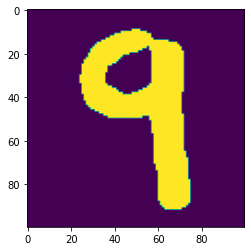

In [ ]:
for img, real in test_ds.take(1):
  i = 2
  pred = np.argmax(model.predict(img),-1)+10
  plt.imshow(img[i].numpy().squeeze(-1))
  print('actual: ',mp[real.numpy()[i]+10],'\npredicted: ',mp[pred[i]])

In [ ]:
m = tf.metrics.Accuracy()
for img, real in test_ds:
  pred = np.argmax(model.predict(img),-1)
  m.update_state(real, pred)
print("Accuracy: ",m.result().numpy())

Accuracy:  0.9075613


In [ ]:
!mkdir letter_model
model.save(root + "letter_model/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/mosaic/letter_model/assets
